# Adversarial attacks on zeolites using the pretrained models

In this notebook, we perform an adversarial attack on zeolites using the [SchNet NN potential](https://github.com/learningmatter-mit/NeuralForceField). We will be using the second generation of zeolite models, as shown in our paper.

The utilities at `nff` will be used to perform the energy/force predictions. `nglview` will be used to visualize the generated trajectories. A few utility functions from this repo, `robust`, will be used as well. For the sake of generality, all steps for performing the adversarial attack are shown in this notebook.

In [1]:
import os
import sys
sys.path.append('..')

import random
import robust as rb
import torch as ch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from nff.io import NeuralFF, AtomsBatch, EnsembleNFF
from nff.data import Dataset
from nff.train import load_model

from ase.io import Trajectory, read

import nglview as nv

## Loading the dataset, models and initial geometry

In [2]:
DEVICE = 1

dset = Dataset.from_file('../data/zeolite.pth.tar')

PATH = '../models/zeolite'
models = []
for model_name in sorted(os.listdir(PATH)):
    m = NeuralFF.from_file(os.path.join(PATH, model_name), device=DEVICE).model
    models.append(m)

ensemble = EnsembleNFF(models, device=DEVICE)

In [3]:
CUTOFF = 5

def get_atoms(props):
    atoms = AtomsBatch(
        positions=props['nxyz'][:, 1:],
        numbers=props['nxyz'][:, 0],
        cell=props['lattice'],
        pbc=True,
        cutoff=CUTOFF,
        props={'energy': 0, 'energy_grad': []},
        calculator=ensemble,
        nbr_torch=False,
        device=DEVICE,
    )
    _ = atoms.update_nbr_list()
    
    return atoms

initial = get_atoms(random.choice(dset))

## Defining the adversarial attack

The `Attacker` class allows one to perform an adversarial attack using an ensemble of SchNet models.

In [4]:
energies_per_atom = ch.tensor(dset.props['energy']) / dset.props['num_atoms']

energy_dset = rb.PotentialDataset(
    ch.zeros_like(energies_per_atom),
    energies_per_atom,
    energies_per_atom,
)

loss_fn = rb.loss.AdvLoss(
    train=energy_dset,
    temperature=20,
)

../robust/data.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return ch.tensor(tensor).reshape(len(tensor), -1)
../robust/data.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return ch.tensor(tensor)


In [5]:
attacker = rb.schnet.Attacker(
    initial,
    ensemble,
    loss_fn,
    device=DEVICE,
)

In [6]:
results = attacker.attack(epochs=100)

100%|██████████| 100/100 [00:13<00:00,  7.62it/s]


## Post-processing the results: visualizing and plotting

After the adversarial attack is performed, we can now visualize it and post-process the results. We start by recalculating the variance in forces and energies.

In [7]:
df = pd.DataFrame(results)
df['forces_var'] = [f.var(-1).mean() for f in df['forces']]
df['energy_var'] = [e.var() for e in df['energy']]
df['energy_avg'] = [e.mean() for e in df['energy']]

Then, we reconstruct the trajectory of the adversarial attack using the values of `delta` along the attack.

In [8]:
newatoms = []
for transl in df.delta:
    at = initial.copy()
    at.translate(transl)
    newatoms.append(at)

In [9]:
view = nv.show_asetraj(newatoms)
view.add_unitcell()

view

NGLWidget(max_frame=99)

Finally, we can plot the trajectory of the adversarial attack based on the sampled properties shown before (see Fig. S10 of the paper). Notice how the geometry that maximizes the adversarial loss is not necessarily the one with highest energy.

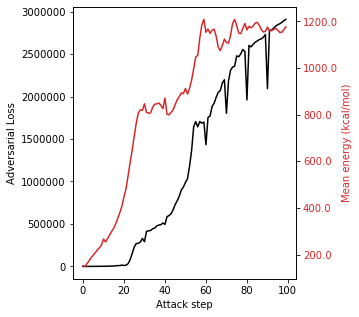

In [10]:
fig, ax = plt.subplots(figsize=(4, 5))
ax.spines['right'].set_visible(True)

ax.plot(-df.loss, color='k')

ax.set_ylabel('Adversarial Loss')

COLOR_TAX = '#d62728'
tax = ax.twinx()
tax.plot(df.energy_avg, color=COLOR_TAX)
tax.set_yticklabels(
    tax.get_yticks(),
    color=COLOR_TAX
)
tax.set_ylabel('Mean energy (kcal/mol)', color=COLOR_TAX)

ax.set_xlabel('Attack step')

plt.show()